# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [2]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



ModuleNotFoundError: No module named 'kagglehub'

## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [4]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?


**1.2:**  How will your solution be used?


**1.3:**  How should success (or failure) be measured?


## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [5]:
home_info_dataframe = df
home_info_dataframe
pd.options.display.max_columns = 500

In [6]:
home_info_dataframe.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34185120.0,-118414640.0,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266.0,LAR3,6.037124e+07,12447.0,3101.0,268548.0,96451.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


In [7]:
home_info_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

In [8]:
home_info_dataframe.nunique()

parcelid                        77414
airconditioningtypeid               5
architecturalstyletypeid            5
basementsqft                       43
bathroomcnt                        22
bedroomcnt                         16
buildingclasstypeid                 2
buildingqualitytypeid              12
calculatedbathnbr                  21
decktypeid                          1
finishedfloor1squarefeet         1787
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
finishedsquarefeet13               13
finishedsquarefeet15             1724
finishedsquarefeet50             1807
finishedsquarefeet6               350
fips                                3
fireplacecnt                        5
fullbathcnt                        13
garagecarcnt                       14
garagetotalsqft                   839
hashottuborspa                      1
heatingorsystemtypeid              10
latitude                        64038
longitude                       62461
lotsizesquar

In [9]:
unique_df = pd.DataFrame(home_info_dataframe.nunique())

not_enough_unique = unique_df[unique_df[0] <= 10]
print(not_enough_unique)

                           0
airconditioningtypeid      5
architecturalstyletypeid   5
buildingclasstypeid        2
decktypeid                 1
fips                       3
fireplacecnt               5
hashottuborspa             1
heatingorsystemtypeid     10
poolcnt                    1
pooltypeid10               1
pooltypeid2                1
pooltypeid7                1
regionidcounty             3
storytypeid                1
threequarterbathnbr        4
typeconstructiontypeid     4
unitcnt                    8
numberofstories            4
fireplaceflag              1
assessmentyear             1
taxdelinquencyflag         1


In [10]:
percent_missing = home_info_dataframe.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': home_info_dataframe.columns,
                                 'percent_missing': percent_missing})

missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,column_name,percent_missing
parcelid,parcelid,0.000000
assessmentyear,assessmentyear,0.043807
roomcnt,roomcnt,0.043807
regionidcounty,regionidcounty,0.043807
bathroomcnt,bathroomcnt,0.043807
bedroomcnt,bedroomcnt,0.043807
rawcensustractandblock,rawcensustractandblock,0.043807
propertylandusetypeid,propertylandusetypeid,0.043807
propertycountylandusecode,propertycountylandusecode,0.043807
longitude,longitude,0.043807


In [ ]:

rows_too_many_missing = missing_value_df[missing_value_df["percent_missing"] > 75]
print(rows_too_many_missing)

                                       column_name  percent_missing
numberofstories                    numberofstories        77.324675
poolcnt                                    poolcnt        79.160708
pooltypeid7                            pooltypeid7        80.571554
threequarterbathnbr            threequarterbathnbr        86.978985
fireplacecnt                          fireplacecnt        89.320088
finishedfloor1squarefeet  finishedfloor1squarefeet        92.221664
finishedsquarefeet50          finishedsquarefeet50        92.221664
finishedsquarefeet15          finishedsquarefeet15        96.099880
taxdelinquencyyear              taxdelinquencyyear        96.263513
taxdelinquencyflag              taxdelinquencyflag        96.263513
yardbuildingsqft17              yardbuildingsqft17        96.916754
hashottuborspa                      hashottuborspa        98.017085
pooltypeid2                            pooltypeid2        98.616211
poolsizesum                            poolsizes

#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

In [12]:
# Display the columns with object data type
print(home_info_dataframe.select_dtypes(include='object').columns)
print('-----------------------------------------------------------------------\n')
# check null values in the categorical columns
print(home_info_dataframe[home_info_dataframe.select_dtypes(include='object').columns].isnull().sum())
print('-----------------------------------------------------------------------\n')
#check unique values in the categorical columns
print(home_info_dataframe[home_info_dataframe.select_dtypes(include='object').columns].nunique())


Index(['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc',
       'fireplaceflag', 'taxdelinquencyflag'],
      dtype='object')
-----------------------------------------------------------------------

hashottuborspa               76074
propertycountylandusecode       34
propertyzoningdesc           27137
fireplaceflag                77441
taxdelinquencyflag           74713
dtype: int64
-----------------------------------------------------------------------

hashottuborspa                  1
propertycountylandusecode      75
propertyzoningdesc           1907
fireplaceflag                   1
taxdelinquencyflag              1
dtype: int64



1. There are 5 categorical columns and 3 columsn have >90% nulls (hashottuborspa, fireplaceflag, and taxdelinquencyflag)
2. hashottuborspa, fireplaceflag, and taxdelinquencyflag: Since these columns have only 1 unique value, they might not provide useful information for modeling. You might consider dropping these columns if they don’t add value to your analysis.

**So we can drop those 3 columns**

3. Looks like propertycountylandusecode is have small number of null vaues and useful for house pricing.
4. propertyzoningdesc is relate to description of zoning and have ~35% of null values. Since it is corelated with other filed, we can probably drop this field too.

**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

- **parcelid**
**Reason**: This is simply a unique identifier for each property. It does not carry any predictive value for modeling unless you're doing property tracking or joins across datasets.

- **rawcensustractandblock and censustractandblock**
**Reason**: These are extremely granular identifiers for census tracts and blocks, mostly useful for geospatial analyses. They’re highly unique and may not add predictive value unless combined with external socioeconomic data.

- **assessmentyear** 
**Reason**: All values appear to be from the same year (2016), so there's no variation to help with predictions.

- **taxdelinquencyflag and taxdelinquencyyear**
**Reason**: If the vast majority of rows are null or "No", the information may not be useful unless analyzing tax compliance.

- **fireplaceflag**
**Reason**: This is a binary flag that likely duplicates the fireplacecnt column (which gives the actual number). If both exist, the flag may be redundant.

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

Based on the percentage of missing values I think there are several examples of features that are not needed, buildingclasstypeid(99.980673), finishedsquarefeet13(99.945885), basementsqft(99.935578), storytypeid(99.935578), yardbuildingsqft26(99.909809), pooltypeid10(99.400874), hashottuborspa(98.017085), pooltypeid2(98.616211), decktypeid(99.208895), architecturalstyletypeid(99.733292), storytypeid(99.935578), fireplaceflag(99.778388), typeconstructiontypeid(99.712677),  taxdelinquencyyear(96.263513), and taxdelinquencyflag(96.263513)

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

Yes.
- **parcelid**
  - **Reason**: This is simply a unique identifier for each property. It does not carry any predictive value for modeling unless you're doing property tracking or joins across datasets.

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

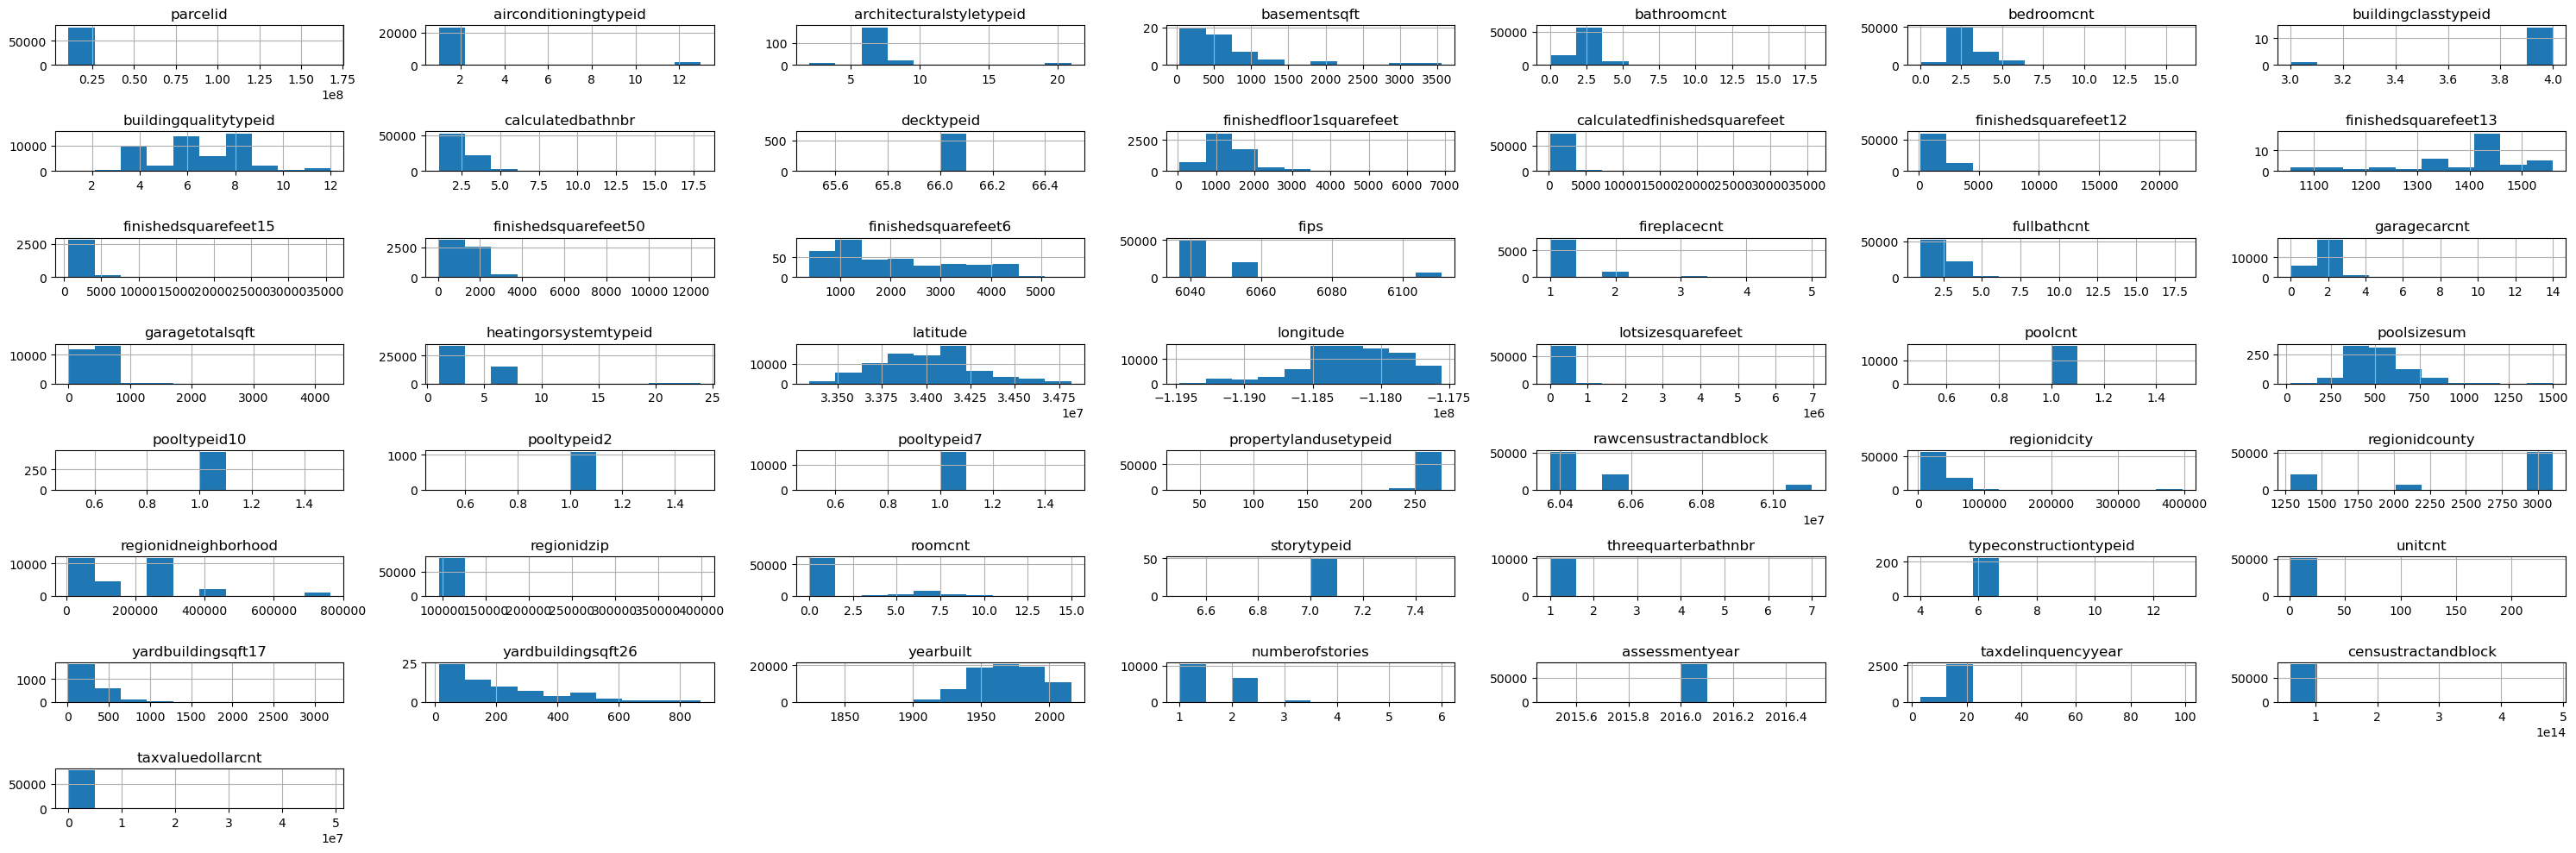

In [ ]:

home_info_dataframe.hist(figsize=(30,10))
plt.tight_layout()
#plt.figure(figsize=(20,10))
None

Text(0, 0.5, 'Counts')

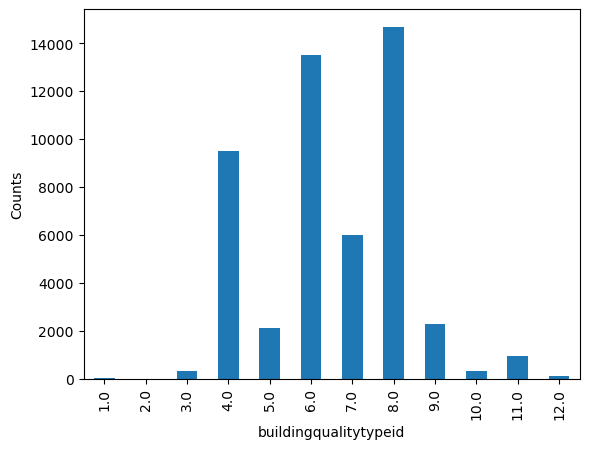

In [ ]:
value_counts_quality = home_info_dataframe["buildingqualitytypeid"].value_counts().sort_index()
value_counts_quality.plot.bar()
plt.ylabel("Counts")

<Axes: >

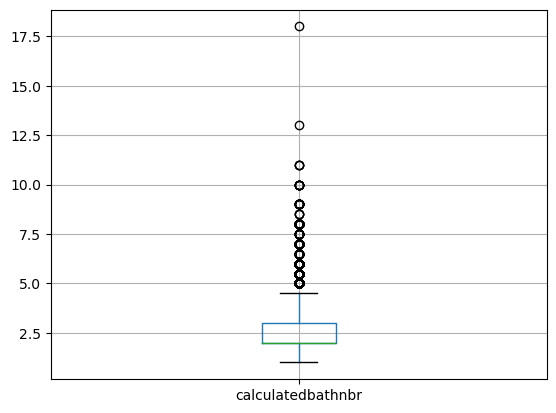

In [ ]:
home_info_dataframe.boxplot(column="calculatedbathnbr")

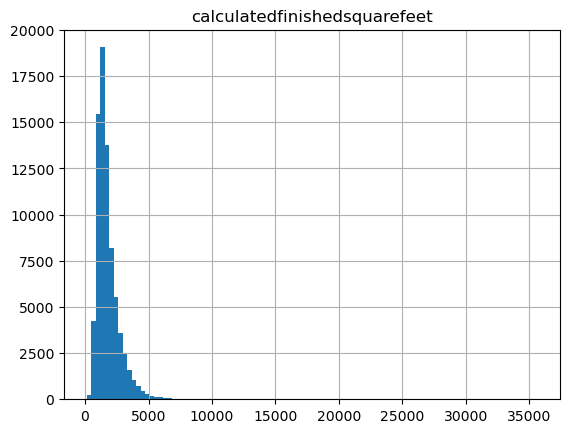

In [ ]:
df.hist(column="calculatedfinishedsquarefeet",bins=100)
None

array([[<Axes: title={'center': 'taxvaluedollarcnt'}>]], dtype=object)

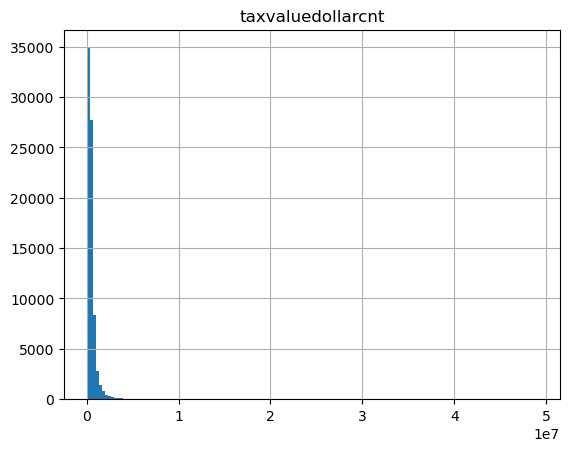

In [ ]:
df.hist(column="taxvaluedollarcnt",bins=150)

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


Feature: buildingqualitytypeid
The distrubution of this looks to be normal, with a slight negative skew, meaning the buildings are more likely to have a higher build quality than not, something interesting about this had been that I had expected 6 to have the largest amount since that would be considered the median, but 8 has a higher count, leading me to believe that this dataset has higher build quality homes potentially overrepesented.

Feature: calculatedbathnbr
I had chosen this to get an idea of the amount of bathrooms and bedrooms in the dataset, and this looks to be what I had expected, with the median looking to be around 2.5 and the largest value not being an outliar being at 17.5(wow thats a large house), there are a few outliars on the upper end and these rows could cause problems due to the massive difference(there are a number of homes with the number above 10 which is almost 5x the median) that could cause a model some errors.

Feature: calculatedfinishedsquarefeet
This distrubution has a positive skew, with homes getting up to around 7500 sqft, which would be considered an outliar.  I had chosen this since bigger homes are thought to usually sell for more and I had assumed this might be a strong indicator of what a home should sell for.

Feature: taxvaluedollarcnt
This looks similar to the previous historgram relating to square feet, with a positive skew.  Since this is the target variable I had wanted to get an idea of it's range.


## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [56]:
dropped_features = home_info_dataframe.drop(columns=
["propertyzoningdesc","taxdelinquencyflag","taxdelinquencyyear", "assessmentyear","parcelid","rawcensustractandblock", "censustractandblock","latitude", "longitude", "pooltypeid10", "pooltypeid2", "pooltypeid7","fips", 'hashottuborspa','fireplaceflag'],inplace=False)

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


- **parcelid**
**Reason**: This is simply a unique identifier for each property. It does not carry any predictive value for modeling unless you're doing property tracking or joins across datasets.

- **rawcensustractandblock and censustractandblock**
**Reason**: These are extremely granular identifiers for census tracts and blocks, mostly useful for geospatial analyses. They’re highly unique and may not add predictive value unless combined with external socioeconomic data.

- **assessmentyear** 
**Reason**: All values appear to be from the same year (2016), so there's no variation to help with predictions.

- **taxdelinquencyflag and taxdelinquencyyear**
**Reason**: If the vast majority of rows are null or "No", the information may not be useful unless analyzing tax compliance.

- **fireplaceflag**
**Reason**: This is a binary flag that likely duplicates the fireplacecnt column (which gives the actual number). If both exist, the flag may be redundant.

- **latitude and longitude**
**Reason**: This is not as indicitive of the area of the house as the other fields such as regionidneighborhood, and regionidzip.  Latitude and Longitudal numbers do not move much when moved a mile, but moving a mile can cause a drastic increase or decrease in home price specifically in urban areas which could make a model more innacurate.

- **pooltypeid10, pooltypeid2, pooltypeid7**
**Reason**: Pools do not add as much value to homes since in certain areas they are not usable for the majority of the year as well as have high costs to maintain as well as insure.  In addition these values contain a large number of null values.

- **fips**
**Reason**: Since this correlates to neighborhoods and counties, we have that covered already and it will be highly correlated with the zip code as well as county information we have, therefore it is not needed 

- **hashottuborspa**
**Reason**: This only has one unique value, and might not provide much value to the model since most homes do not have a hot tub or spa and the ones that do are not likely to be representive of the general population.

- **propertyzoningdesc**
**Reason**: We already have information as to how the property will be used(propertycountylandusecod propertylandusetypeid) and the zoning information will be highly correlated with that, in addition it has a higher number of null values which will not make it as useful for modeling.

### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [57]:
percent_missing_afterDropping = dropped_features.isnull().sum() * 100 / len(dropped_features)
missing_value_afterDropping = pd.DataFrame({'column_name': dropped_features.columns,
                                 'percent_missing': percent_missing_afterDropping})

missing_value_afterDropping.sort_values('percent_missing', inplace=True)

rows_too_many_missing_afterDropping = missing_value_afterDropping[missing_value_afterDropping["percent_missing"] > 95]

cn_ = rows_too_many_missing_afterDropping.loc[rows_too_many_missing_afterDropping["percent_missing"] > 95]
print(np.array(cn_))
cn_null  = [x[0] for x in np.array(cn_)]

dropped_features.drop(columns=cn_null,inplace=True)

[['finishedsquarefeet15' 96.099880174713]
 ['yardbuildingsqft17' 96.91675363663303]
 ['poolsizesum' 98.88034221071213]
 ['decktypeid' 99.20889541700488]
 ['finishedsquarefeet6' 99.502660636749]
 ['typeconstructiontypeid' 99.71267699998711]
 ['architecturalstyletypeid' 99.73329210312706]
 ['yardbuildingsqft26' 99.90980892376277]
 ['basementsqft' 99.93557780268769]
 ['storytypeid' 99.93557780268769]
 ['finishedsquarefeet13' 99.94588535425767]
 ['buildingclasstypeid' 99.9806733408063]]


#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped
These features had been dropped since they did not have enough values to be useful to a model, and in addition had features that not a lot of homes would have.  For instance: decktypeid is only populated if a home has a deck, while decks are certainly not uncommon the average home does not have a deck leaving it unpopulated for over 99% of the dataset, in addition fields such as basementsqft might not be helpful for making a model since basements will not add as much value to a home unless they are finished, and finished basements are more uncommon and do not represent the general population we are trying to model for.  95% was chosen due to the fact that homes having these features could either be outliars(features represent luxuries) or the features had not been logged correctly and are inaccurate, making imputing difficult.

### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [50]:

dropped_features = dropped_features[dropped_features["calculatedbathnbr"] < 4.75]
dropped_features = dropped_features[dropped_features["calculatedfinishedsquarefeet"] < 5000]

#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped
Features had been dropped based off of what had been deemed as an outliar from the graphs that had been made on some of the features. Firstly, homes with more than 4.75 bathrooms had been considered outliars and there had been homes with as many as 17.5 combined bed and bathrooms which is a very high amount.  In addition there had been several other homes with almost 5x the median of combined bathrooms and bedrooms.  In addition, homes with more than 5000 sqft had been deemed as outliars since they had been at the tail end of the histogram that had been made, if these homes had been included in the model they would be much more expensive than the average home.

### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [51]:
dropped_features.fillna(dropped_features.median(),inplace=True)
dropped_features

,airconditioningtypeid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet50,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,lotsizesquarefeet,poolcnt,propertylandusetypeid,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,unitcnt,yearbuilt,numberofstories,taxvaluedollarcnt
0,1.0,3.5,4.0,6.0,3.5,1245.0,3100.0,3100.0,1248.0,1.0,3.0,2.0,633.0,2.0,4506.0,1.0,261.0,53571.0,1286.0,118849.0,96978.0,0.0,1.0,1.0,1998.0,1.0,1023282.0
1,1.0,1.0,2.0,6.0,1.0,1465.0,1465.0,1465.0,1465.0,1.0,1.0,1.0,0.0,2.0,12647.0,1.0,261.0,13091.0,2061.0,118849.0,97099.0,5.0,1.0,1.0,1967.0,1.0,464000.0
2,1.0,2.0,3.0,6.0,2.0,1245.0,1243.0,1243.0,1248.0,1.0,2.0,2.0,440.0,2.0,8432.0,1.0,261.0,21412.0,1286.0,118849.0,97078.0,6.0,1.0,1.0,1962.0,1.0,564778.0
3,1.0,3.0,4.0,8.0,3.0,1245.0,2376.0,2376.0,1248.0,1.0,3.0,2.0,433.0,2.0,13038.0,1.0,261.0,396551.0,3101.0,118849.0,96330.0,0.0,1.0,1.0,1970.0,1.0,145143.0
4,1.0,3.0,3.0,8.0,3.0,1245.0,1312.0,1312.0,1248.0,1.0,3.0,2.0,433.0,2.0,278581.0,1.0,266.0,12447.0,3101.0,268548.0,96451.0,0.0,1.0,1.0,1964.0,1.0,119407.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77608,1.0,3.0,3.0,8.0,3.0,1245.0,1741.0,1741.0,1248.0,1.0,3.0,2.0,433.0,2.0,59487.0,1.0,266.0,12447.0,3101.0,32368.0,96415.0,0.0,1.0,1.0,1980.0,1.0,379000.0
77609,1.0,2.0,2.0,6.0,2.0,1245.0,1286.0,1286.0,1248.0,1.0,2.0,2.0,433.0,2.0,47405.0,1.0,261.0,12447.0,3101.0,27328.0,96284.0,0.0,1.0,1.0,1940.0,1.0,354621.0
77610,1.0,2.0,4.0,6.0,2.0,1612.0,1612.0,1612.0,1612.0,1.0,2.0,2.0,560.0,2.0,12105.0,1.0,261.0,27110.0,2061.0,118849.0,97116.0,7.0,1.0,1.0,1964.0,1.0,67205.0
77611,1.0,1.0,3.0,4.0,1.0,1245.0,1032.0,1032.0,1248.0,1.0,1.0,2.0,433.0,2.0,5074.0,1.0,261.0,36502.0,3101.0,118849.0,96480.0,0.0,1.0,1.0,1954.0,1.0,49546.0


In [52]:
dropped_features.columns

Index(['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet50', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'lotsizesquarefeet', 'poolcnt',
       'propertylandusetypeid', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'threequarterbathnbr',
       'unitcnt', 'yearbuilt', 'numberofstories', 'taxvaluedollarcnt'],
      dtype='object')

#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


For the rows with missing values the median method had been used, while some outliars had been dropped, we had done this since the dataset is fairly large and we did not want to have some of the columns be introduced to outliars.  In addition doing this allows the homes to be more representive of the general population.

### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

In [54]:
print(dropped_features[dropped_features.select_dtypes(include='object').columns].nunique())
#There are no values that need to be encoded

Series([], dtype: float64)


## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

